# Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score, r2_score
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
import seaborn as sns
import plotly.express as px

# Full until 2022

In [3]:
athlete_bio_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Athlete_Bio.csv", index_col='athlete_id')

athlete_event_results_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Athlete_Event_Results.csv")

games_medal_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Games_Medal_Tally.csv")

overall_results_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Results.csv", index_col='result_id')

countries_full = pd.read_csv("Olympics_1986 to 2022/Olympics_Country.csv", index_col='noc')
countries_full = countries_full[countries_full['country']!='ROC'].copy()
countries_full = countries_full[~countries_full['country'].str.contains('East Germany|West Germany')].copy()

games_full = pd.read_csv("Olympics_1986 to 2022/Olympics_Games.csv", index_col='edition')

In [4]:
# Extract only summer games from 1992
games_summer = games_full.loc[games_full.index.str.contains('Summer')].copy()
games_summer = games_summer[~(games_summer['year'] < 1992)].copy()

athlete_event_results_summer = athlete_event_results_full.loc[athlete_event_results_full['edition'].str.contains('Summer')].copy()
athlete_event_results_summer['year'] = athlete_event_results_summer['edition'].str.extract(r'(\d+)').astype('float64').astype('Int64')
athlete_event_results_summer = athlete_event_results_summer[~(athlete_event_results_summer['year'] < 1992)].copy()
athlete_event_results_summer['medal'].fillna('No medal', inplace=True)

overall_results_summer = overall_results_full.loc[overall_results_full['edition'].str.contains('Summer')].copy()
overall_results_summer['year'] = overall_results_summer['edition'].str.extract(r'(\d+)').astype('float64').astype('Int64')
overall_results_summer = overall_results_summer[~(overall_results_summer['year'] < 1992)].copy()

games_medal_summer = games_medal_full.loc[games_medal_full['edition'].str.contains('Summer')].copy()
games_medal_summer['year'] = games_medal_summer['edition'].str.extract(r'(\d+)').astype('float64').astype('Int64')
games_medal_summer = games_medal_summer[~(games_medal_summer['year'] < 1992)].copy()
games_medal_summer.loc[(games_medal_summer['country'] == 'ROC'),'country'] = 'Russian Olympic Committee'


# Drop rows having index in [2024, 2028, 2032]
games_summer = games_summer[~games_summer.index.str.contains('2024|2028|2032')].copy()

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/1921465289.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  athlete_event_results_summer['medal'].fillna('No medal', inplace=True)


In [5]:
# Number of athletes per year
nathlete_per_year = pd.DataFrame(athlete_event_results_summer.groupby(['edition']).athlete_id.nunique().copy())
nathlete_per_year.rename(columns={'athlete_id':'athlete_count'}, inplace=True)
nathlete_per_year.reset_index(inplace=True)

# Comparisions of Olympics' total medals and number of athletes over the year for Summer
## Comments:
- These two graphs show an increasing trend of athletes participating in the Olympic events and medals being awarded.
- There is a noise around 2012. The number of athletes decreased but the number of total medals remained the same. This can be explained by the Greata Recession event. 

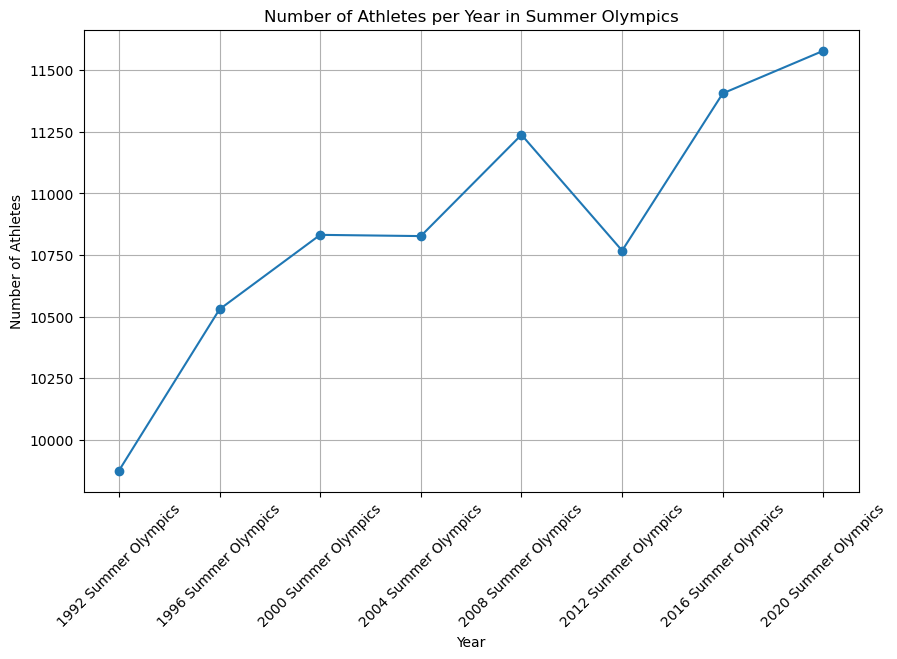

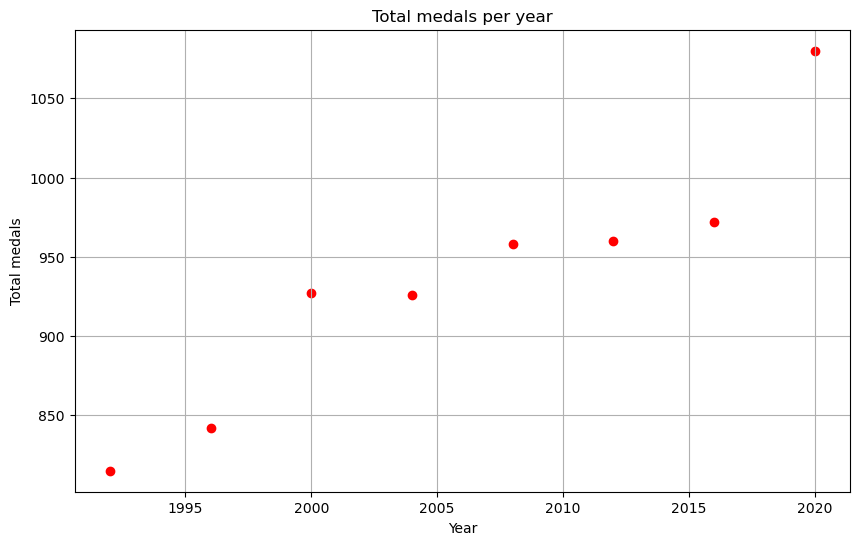

In [6]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(nathlete_per_year['edition'], nathlete_per_year['athlete_count'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Athletes')
plt.title('Number of Athletes per Year in Summer Olympics')
plt.grid(True)
plt.xticks(rotation=45)

country_medal = pd.DataFrame(games_medal_summer.groupby('year')['total'].sum()).reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(pd.DataFrame(games_medal_summer.groupby('year')['total'].sum()).reset_index()['year'], pd.DataFrame(games_medal_summer.groupby('year')['total'].sum()).reset_index()['total'], color="red")
plt.xlabel('Year')
plt.ylabel('Total medals')
plt.title('Total medals per year')
plt.grid(True)
plt.show()

# Countries vs. percentage medal
## Comment:
- It seems like countries that originally did well continue to do well in the following years.
- Great Britain shows an increase in number of medals as number of players increases.

In [7]:
def plot_country_vs_percent(year, percent):
    data = games_medal_summer[(games_medal_summer['year']==year)]
    data = data[['year','percent','country']]
    less_than_2 = data[data['percent'] < percent]
    sum_percent_less_than_2 = less_than_2['percent'].sum()
    new_row = pd.DataFrame([[2004, sum_percent_less_than_2, 'Other']], columns=['year', 'percent', 'country'])
    data = pd.concat([data, new_row], ignore_index=True)
    data = data[data['percent'] >= percent]

    plt.figure(figsize=(10, 7))
    plt.pie(data['percent'], labels=data['country'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Medal Percentage by Country in {year}')
    plt.axis('equal')
    plt.show()

In [8]:
games_medal_summer = pd.merge(country_medal, games_medal_summer, on='year', how='inner')
games_medal_summer.rename(columns={'total_x':'Total per year','total_y':'Total per country'}, inplace=True)
games_medal_summer['percent'] = games_medal_summer['Total per country'] / games_medal_summer['Total per year'] * 100
games_medal_summer['country'] = games_medal_summer['country'].str.strip()

In [9]:
games_medal_summer[games_medal_summer['country_noc'].str.contains('GDR')]

,year,Total per year,edition,edition_id,country,country_noc,gold,silver,bronze,Total per country,percent


In [10]:
print(sorted(list(games_medal_summer['country'].unique())))

['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Bermuda', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Chile', 'Chinese Taipei', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Great Britain', 'Greece', 'Grenada', 'Guatemala', 'Hong Kong, China', 'Hungary', 'Iceland', 'Independent Olympic Athletes', 'India', 'Indonesia', 'Ireland', 'Islamic Republic of Iran', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kingdom of Saudi Arabia', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Malaysia', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Netherl

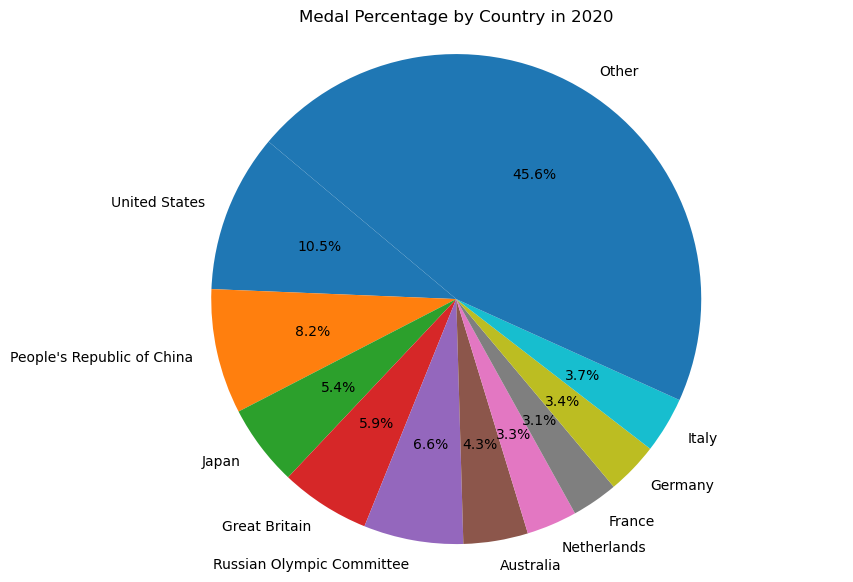

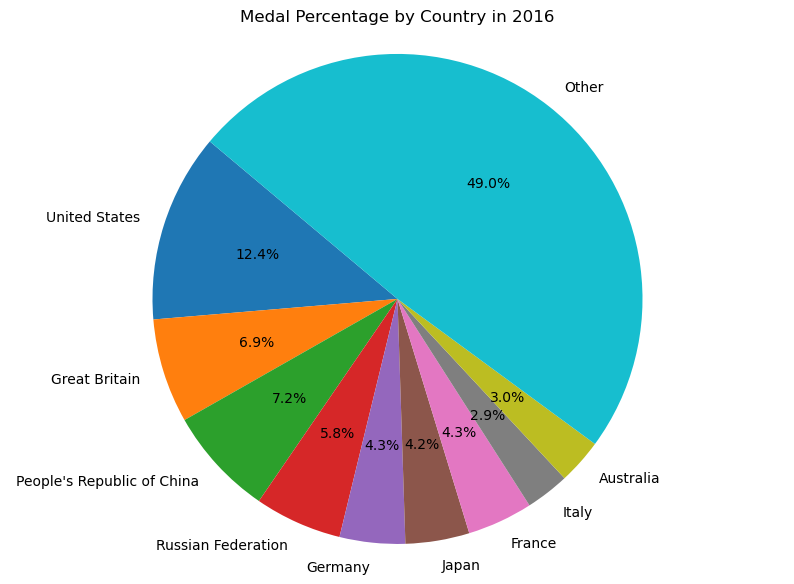

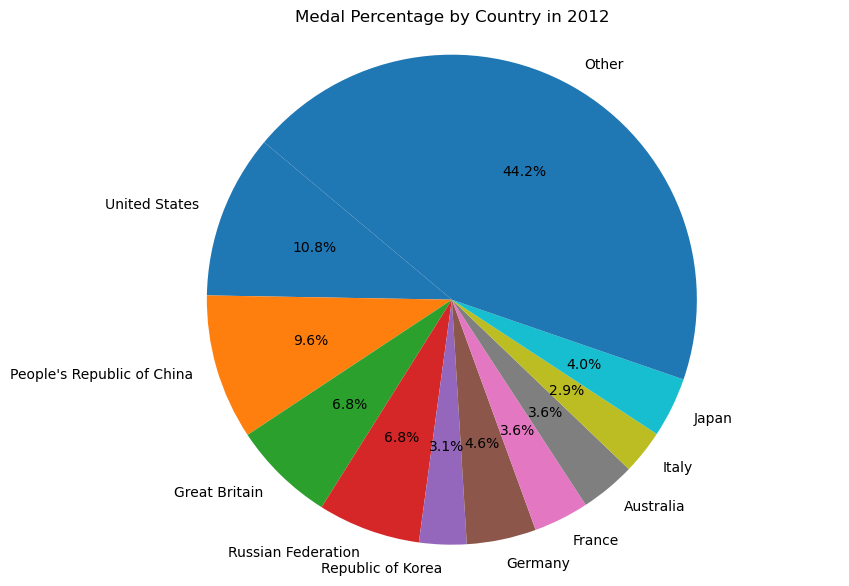

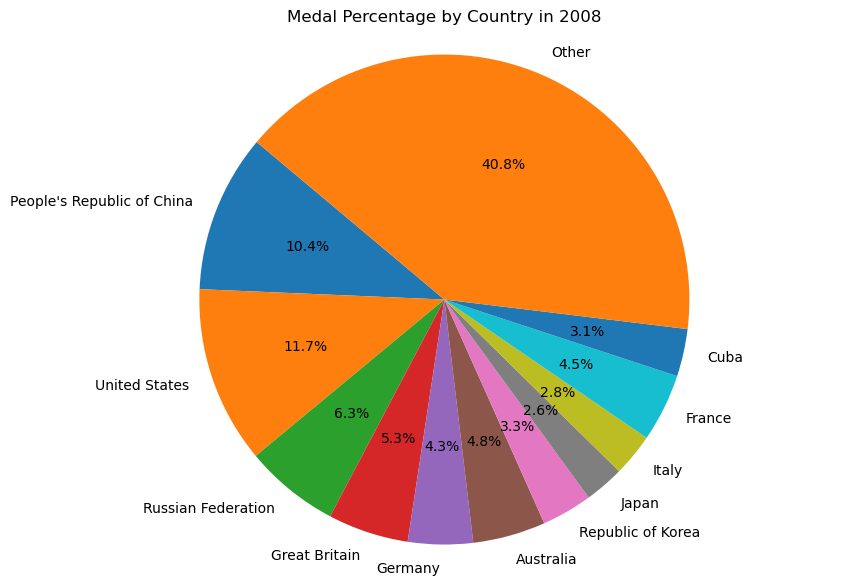

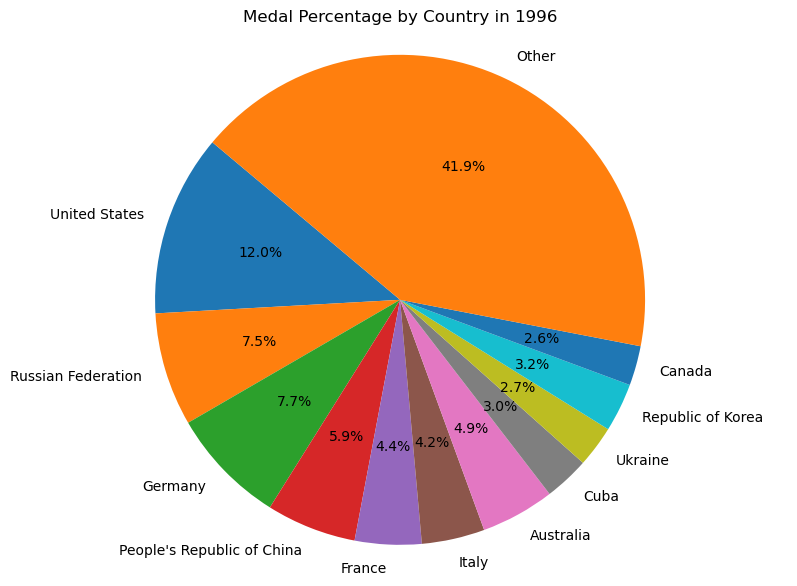

In [11]:
plot_country_vs_percent(2020, 2.5)
plot_country_vs_percent(2016,2.5)
plot_country_vs_percent(2012,2.5)
plot_country_vs_percent(2008,2.5)
plot_country_vs_percent(1996,2.5)

# Countries vs. # participants
## Comment:
- The below plot is an explanation for the increase of medals winning from Great Britian since around 2012.

In [13]:
athlete_full_info = pd.merge(athlete_event_results_summer, athlete_bio_full, how='outer', on='athlete_id').reset_index()
athlete_full_info['country_noc_x'] = athlete_full_info['country_noc_y']
athlete_full_info.drop(columns=['country_noc_y'], inplace=True)
athlete_full_info.rename(columns={'country_noc_x':'country_noc'}, inplace=True)
athlete_full_info['edition_id'].fillna(0,inplace=True)
athlete_full_info['result_id'].fillna(0,inplace=True)
athlete_full_info['medal'].fillna('No medal', inplace=True)
athlete_full_info['born'].fillna('0000', inplace=True)


athlete_full_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206440 entries, 0 to 206439
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          206440 non-null  int64  
 1   edition        111271 non-null  object 
 2   edition_id     206440 non-null  float64
 3   country_noc    206440 non-null  object 
 4   sport          111271 non-null  object 
 5   event          111271 non-null  object 
 6   result_id      206440 non-null  float64
 7   athlete        111271 non-null  object 
 8   athlete_id     206440 non-null  int64  
 9   pos            111271 non-null  object 
 10  medal          206440 non-null  object 
 11  isTeamSport    111271 non-null  object 
 12  year           111271 non-null  Int64  
 13  name           206440 non-null  object 
 14  sex            206440 non-null  object 
 15  born           206440 non-null  object 
 16  height         152445 non-null  float64
 17  weight         152445 non-nul

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/1393014818.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  athlete_full_info['edition_id'].fillna(0,inplace=True)
/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/1393014818.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [14]:
country_participants = pd.DataFrame(athlete_full_info.groupby(['year','country_noc']).size()).reset_index()
country_participants = pd.merge(country_participants, countries_full, how='outer', left_on='country_noc', right_on='noc')
country_participants.rename(columns={0: 'total players'}, inplace=True)
country_participants.sort_values(by=['year','total players'], inplace=True)
country_participants.dropna(axis='rows', subset='year', inplace=True)
country_participants.dropna(axis='rows', subset='country', inplace=True)

<Figure size 1000x800 with 0 Axes>

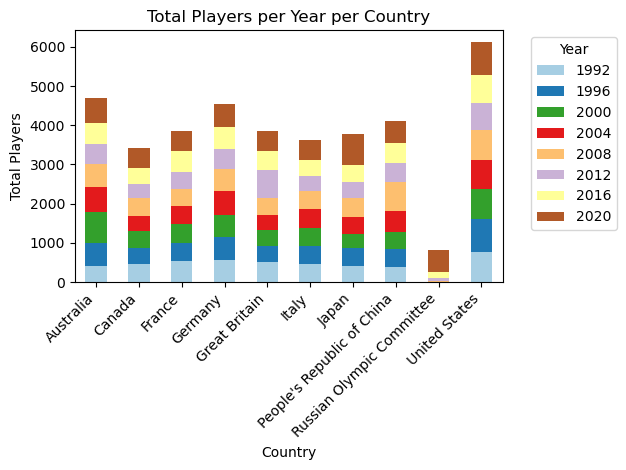

In [15]:
sample = country_participants[country_participants['country'].isin(['United States','Germany','Australia','Japan','Great Britain','Canada','Italy','France','Russian Olympic Committee',"People's Republic of China"])]
pivot_data = sample.pivot_table(index='country', columns='year', values='total players', aggfunc='sum')

# Create a stacked bar plot
plt.figure(figsize=(10, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='Paired')
plt.xlabel('Country')
plt.ylabel('Total Players')
plt.title('Total Players per Year per Country')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Age vs. performance
## Comment:
- It seems like people with higher age, which might mean having more experience, are likely to get more medals

In [16]:
athlete_full_info.columns

Index(['index', 'edition', 'edition_id', 'country_noc', 'sport', 'event',
       'result_id', 'athlete', 'athlete_id', 'pos', 'medal', 'isTeamSport',
       'year', 'name', 'sex', 'born', 'height', 'weight', 'country',
       'description', 'special_notes'],
      dtype='object')

In [17]:
df = athlete_full_info[['result_id','medal','born','athlete_id','country','country_noc']]
df['born'].fillna('0000',inplace=True)
df['born'] = df['born'].str[-4:]

# idx = df[df['born'].str.contains('\)')].index
df = df.loc[~df['born'].str.contains('\)')]
df = df.loc[~df['born'].str.contains('0000')]
df['born'] = pd.to_numeric(df['born'])
df = df.loc[~(df['born'] < 1992)]

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/2761305930.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['born'].fillna('0000',inplace=True)
/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/2761305930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['born'].fillna('0000',inplace=True)
/var/folder

In [18]:
df2 = pd.DataFrame(df.groupby(['born','medal']).value_counts())
df2

count
born medal    result_id  athlete_id country                    country_noc       
1992 Bronze   259060.0   116030     People's Republic of China CHN              1
              259982.0   117646     People's Republic of China CHN              1
              259985.0   117662     Romania                    ROU              1
                         117664     Romania                    ROU              1
              259994.0   117646     People's Republic of China CHN              1
...                                                                           ...
2007 No medal 18000391.0 143327     Germany                    GER              1
2008 Bronze   18000391.0 143068     Great Britain              GBR              1
     Silver   18000377.0 141168     Brazil                     BRA              1
              18000391.0 144431     Japan                      JPN              1
2009 No medal 19004030.0 146782     Syrian Arab Republic       SYR              1

[20917 rows x 1 columns]

<Figure size 1000x800 with 0 Axes>

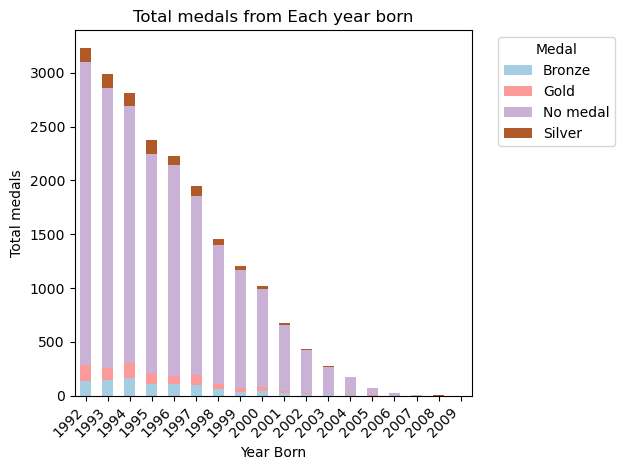

In [19]:
pivot_data2 = df2.pivot_table(index='born', columns='medal', values='count', aggfunc='sum')

# Create a stacked bar plot
plt.figure(figsize=(10, 8))
pivot_data2.plot(kind='bar', stacked=True, colormap='Paired')
plt.xlabel('Year Born')
plt.ylabel('Total medals')
plt.title('Total medals from Each year born')
plt.legend(title='Medal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Being host vs. performance
## Comment:
- It's likely that there's no relationship between being the hosted country and number of medals gained

In [20]:
games_summer['year'] = games_summer.index.str[:4]
games_summer['year'] = pd.to_numeric(games_summer['year'])
games_summer.reset_index(inplace=True)
games_summer.drop(columns=['edition','country_flag_url','competition_date','start_date','end_date','edition_url','isHeld'], axis=1, inplace=True)

In [21]:
games_summer.head()

,edition_id,year,city,country_noc
0,23,1992,Barcelona,ESP
1,24,1996,Atlanta,USA
2,25,2000,Sydney,AUS
3,26,2004,Athina,GRE
4,53,2008,Beijing,CHN


/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/72143175.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(merged_df['country'])


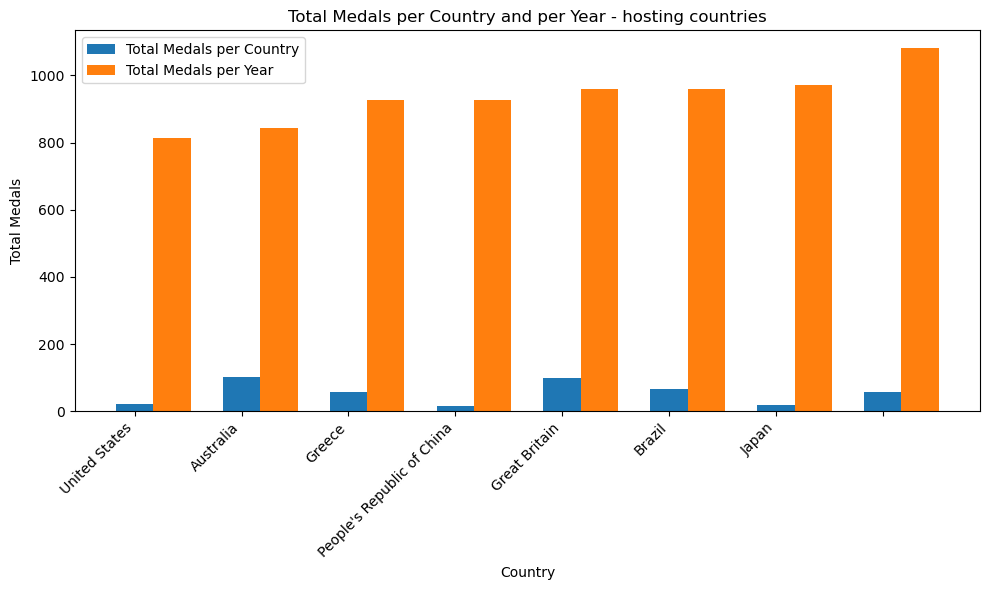

In [22]:
merged_df = pd.merge(games_summer, games_medal_summer, left_on=['year', 'country_noc'], right_on=['year', 'country_noc'], how='left')

fig, ax = plt.subplots(figsize=(10, 6))

# Number of bars
n = len(merged_df)

# Bar width
bar_width = 0.35

# Positions of bars on x-axis
index = np.arange(n)

# Plotting the bars
bar1 = ax.bar(index, merged_df['Total per country'], bar_width, label='Total Medals per Country')
bar2 = ax.bar(index + bar_width, merged_df['Total per year'], bar_width, label='Total Medals per Year')

# Adding labels, title, and customizing
ax.set_xlabel('Country')
ax.set_ylabel('Total Medals')
ax.set_title('Total Medals per Country and per Year - hosting countries')
ax.set_xticklabels(merged_df['country'])
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/2544433344.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['country'])


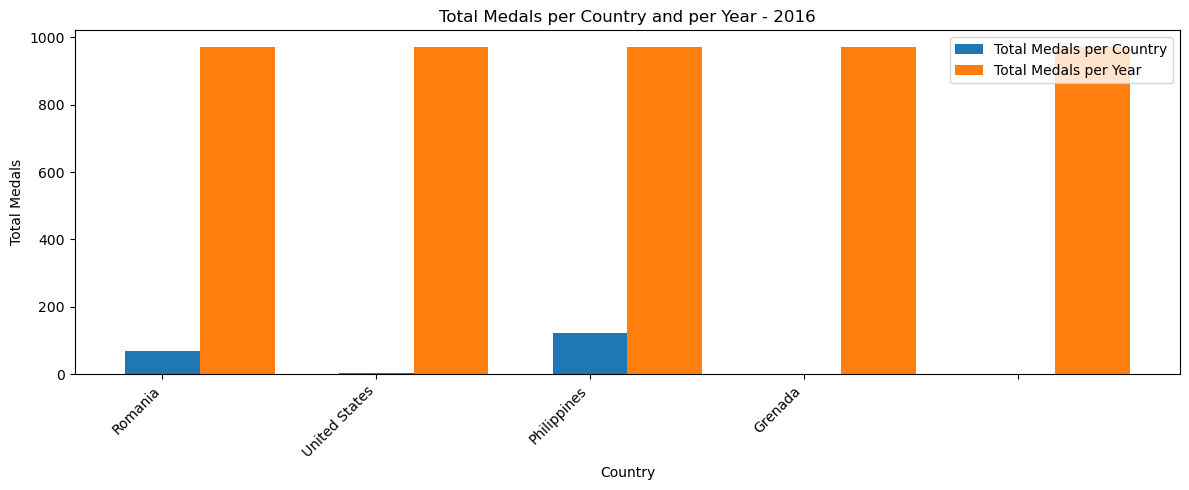

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/2544433344.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['country'])


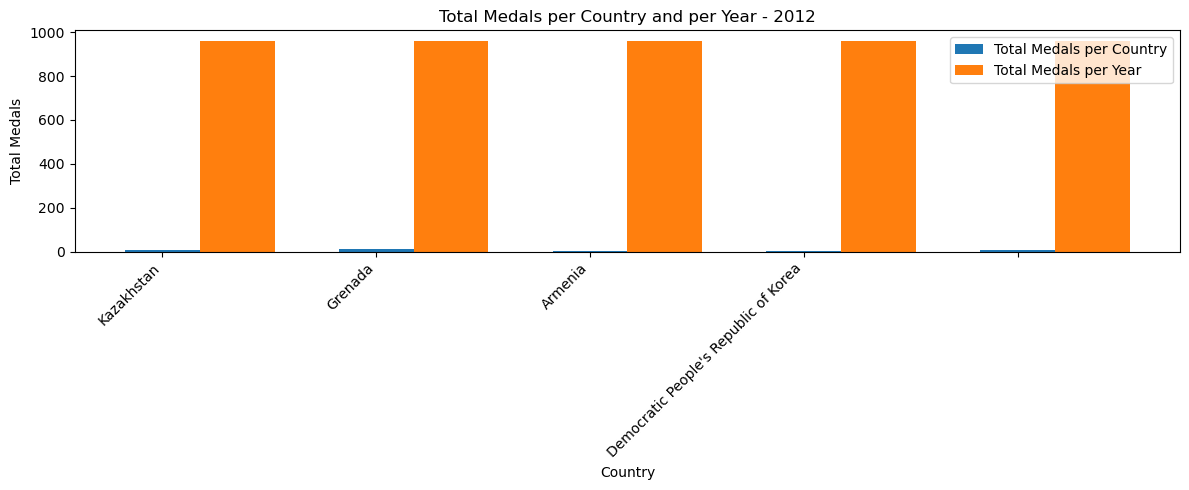

In [23]:
def plot_per_country_year(year):
    df = (games_medal_summer[(games_medal_summer['year'] == year) & (~games_medal_summer['country_noc'].isin(games_summer.loc[games_summer['year'] == year, 'country_noc']))]).sample(n=5)
    fig, ax = plt.subplots(figsize=(12, 5))

    n = len(df)
    bar_width = 0.35
    index = np.arange(n)
    bar1 = ax.bar(index, df['Total per country'], bar_width, label='Total Medals per Country')
    bar2 = ax.bar(index + bar_width, df['Total per year'], bar_width, label='Total Medals per Year')
    ax.set_xlabel('Country')
    ax.set_ylabel('Total Medals')
    ax.set_title(f'Total Medals per Country and per Year - {year}')
    ax.set_xticklabels(df['country'])
    ax.legend()

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_per_country_year(2016)
plot_per_country_year(2012)


# Being Host vs. Profit/Loss Costs
## Comment:
- Summer games tend to have higher cost, which might be due to the preparation stage. The overall cost over the year increases as the number of games/events included increases.
- Overall, losses seem to heavily outweigh profits for host countries, and many stadiums built for the events are left useless afterwards.
- This scatter plot shows the relationship between the final operating budget and total costs for each Olympic event, with a trend line indicating the correlation between these two variables.

In [24]:
data_money = {
    'Olympiad': ['1988 Winter Olympics', '1988 Summer Olympics', '1992 Winter Olympics', '1992 Summer Olympics', 
                 '1994 Winter Olympics', '1996 Summer Olympics', '1998 Winter Olympics', '2000 Summer Olympics', 
                 '2002 Winter Olympics', '2004 Summer Olympics', '2006 Winter Olympics', '2008 Summer Olympics', 
                 '2010 Winter Olympics', '2012 Summer Olympics', '2014 Winter Olympics', '2016 Summer Olympics', 
                 '2018 Winter Olympics', '2020 Summer Olympics', '2022 Winter Olympics'],
    'Host': ['Calgary', 'Seoul', 'Albertville', 'Barcelona', 'Lillehammer', 'Atlanta', 'Nagano', 'Sydney', 
             'Salt Lake City', 'Athens', 'Turin', 'Beijing', 'Vancouver', 'London', 'Sochi', 'Rio de Janeiro', 
             'Pyeongchang', 'Tokyo', 'Beijing'],
    'Final Operating Budget': [438000000, 4000000000, None, 850000000, 1100000000, 1800000000, None, 4471698000, 
                               2000000000, 15000000000, 700000000, 44000000000, 1260000000, 85355877867, 51000000000, 
                               13100000000, 2190000000, 15400000000, 3900000000],
    'Total Costs': [899000000, None, None, 9300000000, None, None, 10000000000, 2032590000, 1200000000, 9000000000, 
                    None, None, 6400000000, 14600000000, None, None, 12900000000, 28000000000, None],
    'Taxpayer Contribution': [425000000, None, 1200000000, None, 250000000, 609000000, 10000000000, 1388936500, 
                              600000000, 6200000000, None, None, 2300000000, 4400000000, None, None, None, None, None],
    'Profit/Loss': [32000000, 479000000, -67000000, 10000000, None, 19000000, None, -2100000000, 101000000, -14500000, 
                    -3200000, 146000000, 2850000, None, 53150000, -2000000000, 55000000, None, 52000000],
    'Year Debt Paid Off': [1988, 1988, None, 1992, None, 1996, None, 2000, 2002, None, None, 2008, 2014, 2012, None, 
                           None, None, None, None]
}

df_money = pd.DataFrame(data_money)
df_money['year'] = df_money['Olympiad'].str[:4]
df_money['type'] = df_money['Olympiad'].str[5:11]
df_money.drop(columns='Olympiad', inplace=True)
df_money['Total Costs'].fillna(0, inplace=True)
df_money['Final Operating Budget'].fillna(0, inplace=True)
df_money['Taxpayer Contribution'].fillna(0, inplace=True)
df_money['Profit/Loss'].fillna(0, inplace=True)

sample = pd.DataFrame(games_full[['city','country_noc']]).reset_index()
sample.drop(columns='edition', inplace=True)
df_money = pd.merge(df_money, sample, left_on='Host', right_on='city', how='inner')
df_money.drop(columns='city',inplace=True)
df_money['year'] = pd.to_numeric(df_money['year'])
pd.set_option('display.float_format', '{:,.2f}'.format)

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/1275649025.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_money['Total Costs'].fillna(0, inplace=True)
/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_61526/1275649025.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [25]:
df_money.head(10)

,Host,Final Operating Budget,Total Costs,Taxpayer Contribution,Profit/Loss,Year Debt Paid Off,year,type,country_noc
0,Calgary,"438,000,000.00","899,000,000.00","425,000,000.00","32,000,000.00","1,988.00",1988,Winter,CAN
1,Seoul,"4,000,000,000.00",0.00,0.00,"479,000,000.00","1,988.00",1988,Summer,KOR
2,Albertville,0.00,0.00,"1,200,000,000.00","-67,000,000.00",NaN,1992,Winter,FRA
3,Barcelona,"850,000,000.00","9,300,000,000.00",0.00,"10,000,000.00","1,992.00",1992,Summer,ESP
4,Lillehammer,"1,100,000,000.00",0.00,"250,000,000.00",0.00,NaN,1994,Winter,NOR
5,Atlanta,"1,800,000,000.00",0.00,"609,000,000.00","19,000,000.00","1,996.00",1996,Summer,USA
6,Nagano,0.00,"10,000,000,000.00","10,000,000,000.00",0.00,NaN,1998,Winter,JPN
7,Sydney,"4,471,698,000.00","2,032,590,000.00","1,388,936,500.00","-2,100,000,000.00","2,000.00",2000,Summer,AUS
8,Salt Lake City,"2,000,000,000.00","1,200,000,000.00","600,000,000.00","101,000,000.00","2,002.00",2002,Winter,USA
9,Beijing,"44,000,000,000.00",0.00,0.00,"146,000,000.00","2,008.00",2008,Summer,CHN


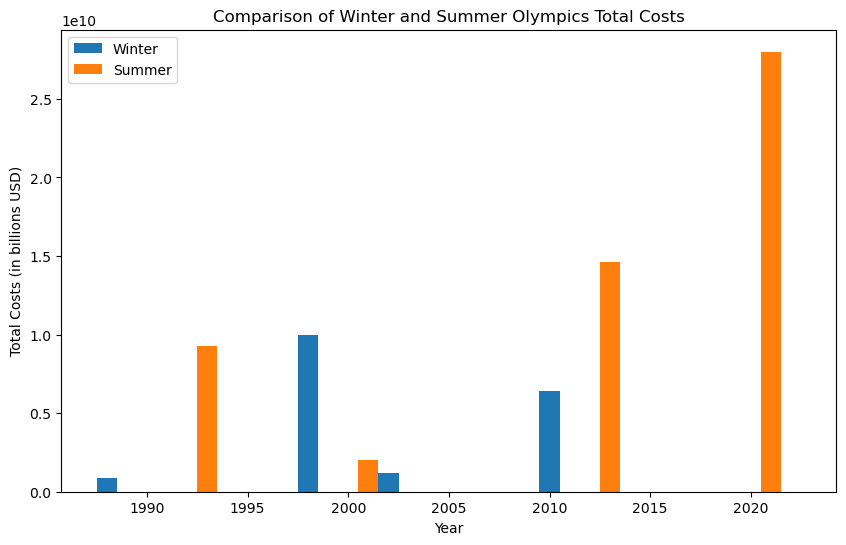

In [26]:
winter_data = df_money[df_money['type'] == 'Winter']
summer_data = df_money[df_money['type'] == 'Summer']

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(winter_data['year'], winter_data['Total Costs'], width=1, label='Winter', align='center')

ax.bar(summer_data['year'] + 1, summer_data['Total Costs'], width=1, label='Summer', align='center')

ax.set_xlabel('Year')
ax.set_ylabel('Total Costs (in billions USD)')
ax.set_title('Comparison of Winter and Summer Olympics Total Costs')
ax.legend()

plt.show()

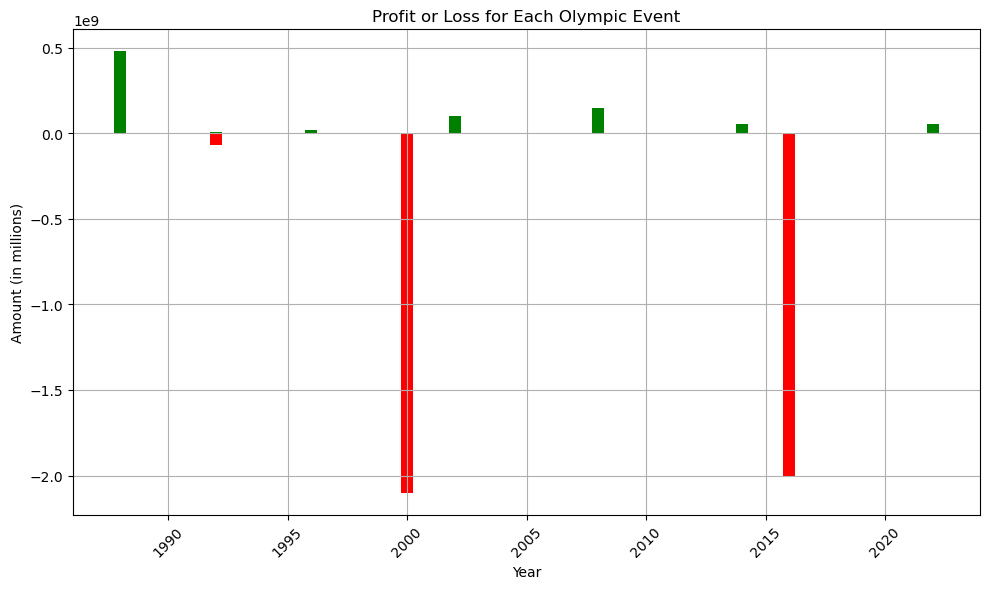

In [36]:
index = df_money['year']
profit_loss = df_money['Profit/Loss']

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in profit_loss]
bar_width = 0.5 

plt.bar(index, profit_loss, width=bar_width, color=colors)
plt.xlabel('Year')
plt.ylabel('Amount (in millions)')
plt.title('Profit or Loss for Each Olympic Event')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

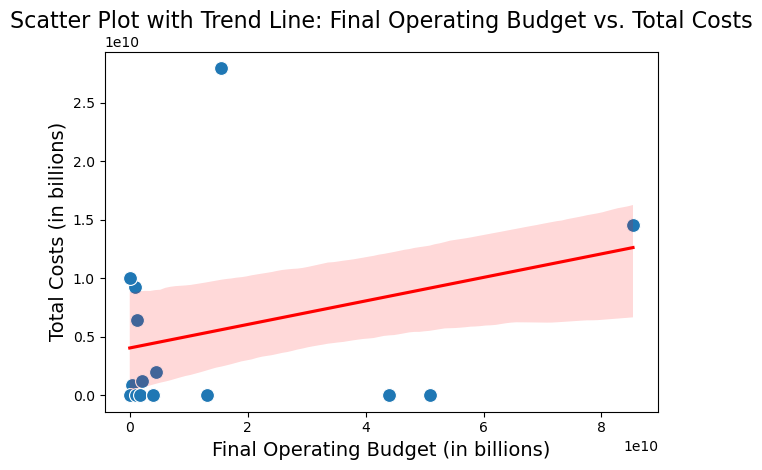

In [28]:
df_filtered = df_money.dropna(subset=['Final Operating Budget', 'Total Costs'])
sns.scatterplot(x='Final Operating Budget', y='Total Costs', data=df_filtered, s=100)
sns.regplot(x='Final Operating Budget', y='Total Costs', data=df_filtered, scatter=False, color='red')
plt.xlabel('Final Operating Budget (in billions)', fontsize=14)
plt.ylabel('Total Costs (in billions)', fontsize=14)
plt.title('Scatter Plot with Trend Line: Final Operating Budget vs. Total Costs', fontsize=16)
plt.tight_layout()

plt.show()

# Medal Trends of Top 10 countries
## Comment:
- United States has been always staying as the first rank, which means that the U.S is most likely to have the most medals for this year.
- China and Great Britian have their medals increase over the year, which might be due to the economic growth.
- Russian and Germany have their medals decrease over the year.

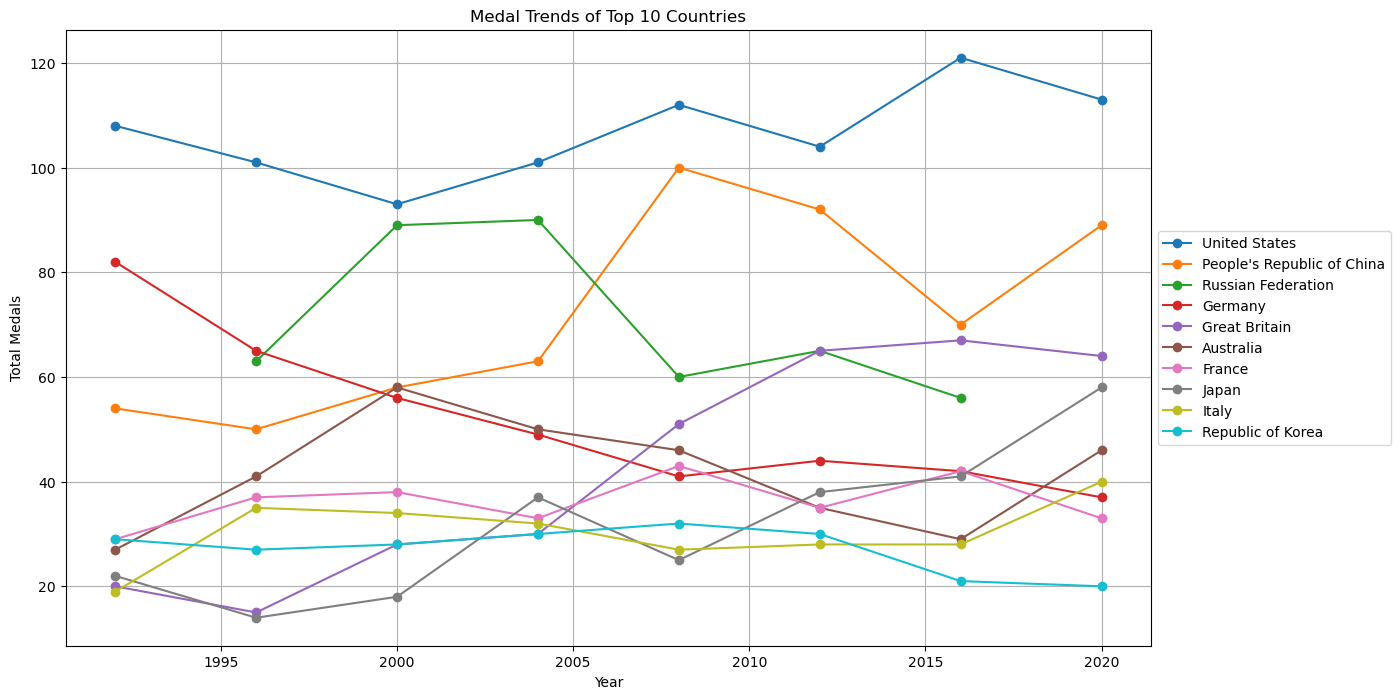

In [29]:
medal_tally_grouped = games_medal_summer.groupby(['year', 'country']).sum().reset_index()
top_countries = medal_tally_grouped.groupby('country').sum().sort_values(by='Total per country', ascending=False).head(10).index
medal_tally_filtered = medal_tally_grouped[medal_tally_grouped['country'].isin(top_countries)]
plt.figure(figsize=(14, 8))
for country in top_countries:
    country_data = medal_tally_filtered[medal_tally_filtered['country'] == country]
    plt.plot(country_data['year'], country_data['Total per country'], marker='o', label=country)

plt.title('Medal Trends of Top 10 Countries')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()